# ARIMA and SARIMA
This notebook develops the arima model.

## Imports:

In [1]:
import os
import pandas as pd
from pathlib import Path
import pmdarima as pm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
import pickle
import sys
sys.path.append(os.path.join('..', 'Helper'))
sys.path.append(os.path.join('..', '..', 'Evaluation', 'Helper'))
from dataPreprocessing import make_stationary, granger_causes, rank_features_ccf, get_untransformed_exog
from evaluation_helpers import display_results

import warnings
warnings.filterwarnings("ignore") 

## Constants:

In [2]:
USE_UNTRANSFORMED= False
VALID_SIZE=12
START_YEAR= 1990
DATA_INFO= "UnTransformed" if USE_UNTRANSFORMED else "Transformed"

## Train Data:

In [3]:

cwd=Path.cwd()
data= pd.read_csv(cwd.parent.parent / 'Data' /'Train'/f'train{START_YEAR}s.csv',parse_dates=[0],date_format='%m%Y',index_col=0)

if USE_UNTRANSFORMED:
    trainDf = get_untransformed_exog(data)
else:
    trainDf= data

y_train_full= trainDf["fred_PCEPI"]
X_train_full= trainDf.drop("fred_PCEPI",axis=1)

X_train, X_valid, y_train, y_valid=train_test_split(trainDf.drop("fred_PCEPI",axis=1), trainDf["fred_PCEPI"],shuffle=False, test_size=VALID_SIZE)

##  Test Data:

In [4]:
test_data=pd.read_csv(cwd.parent.parent / 'Data' /'Test'/f'test{START_YEAR}s.csv',parse_dates=[0],date_format='%m%Y',index_col=0)
if USE_UNTRANSFORMED:
    testDf = get_untransformed_exog(test_data)
else:
    testDf= test_data

y_test= testDf['fred_PCEPI']
X_test= testDf.drop('fred_PCEPI', axis=1)

# Preprocessing
ARIMA requires the data to be stationary, however AutoArima kindly handles it for you!

# ARIMA

2025-03-30 20:10:51,303 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-30 20:10:51,307 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-30 20:10:51,309 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-30 20:10:51,312 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


RMSE: 1.033915701440104


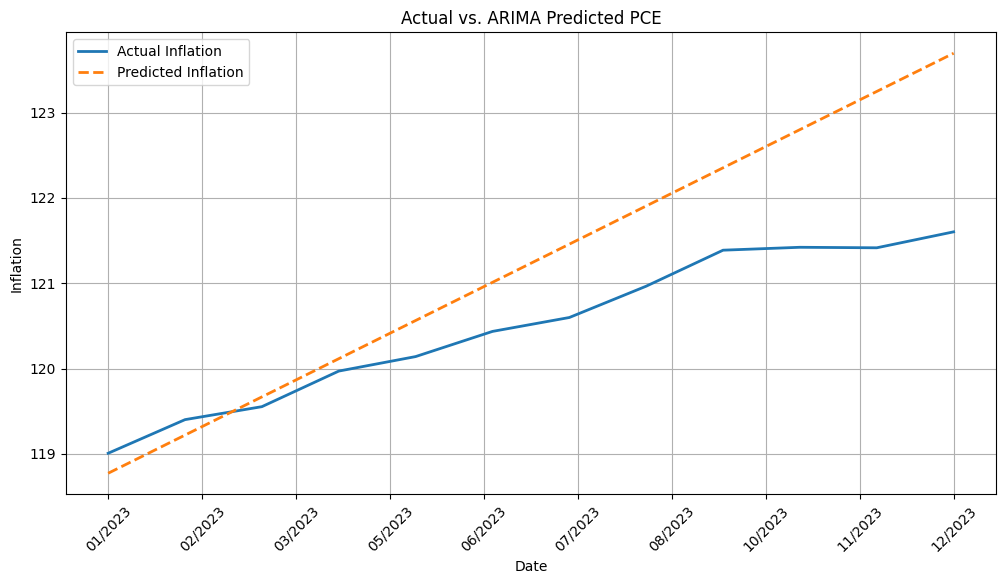

In [5]:
#Make seasonal False for ARIMA (otherwise its SARIMA)
arima_model= pm.auto_arima(y_train,start_p=1, start_q=1,seasonal=False, stepwise=True)
preds=np.array(arima_model.predict(y_valid.shape[0]))
Y= np.array(y_valid.iloc[:])

#could instead use evaluate_model here, consider changing
print(f'RMSE: {root_mean_squared_error(Y,preds)}')
display_results(Y, preds, list(y_valid.index), 'ARIMA', print_dates=10)
plt.show()

In [6]:
arima_full_train= pm.auto_arima(y_train_full,start_p=1, start_q=1,seasonal=False, stepwise=True)
with open(f'ARIMA{START_YEAR}{DATA_INFO}.pkl','wb') as f:
    pickle.dump(arima_full_train,f)

# ARIMAX

In [ ]:
#Make seasonal False for ARIMAX (otherwise its SARIMA)
arimax_model= pm.auto_arima(y=y_train,X=X_train,start_p=1, start_q=1,seasonal=False, stepwise=True)
preds=np.array(arimax_model.predict(y_valid.shape[0],X_valid))
Y= np.array(y_valid)

print(f'RMSE: {root_mean_squared_error(Y,preds)}')
display_results(Y, preds, list(y_valid.index), 'ARIMAX', print_dates=10)
plt.show()

## SARIMA

2025-03-30 20:11:14,852 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-30 20:11:14,854 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-30 20:11:14,858 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-30 20:11:14,860 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


RMSE: 0.874766167107437


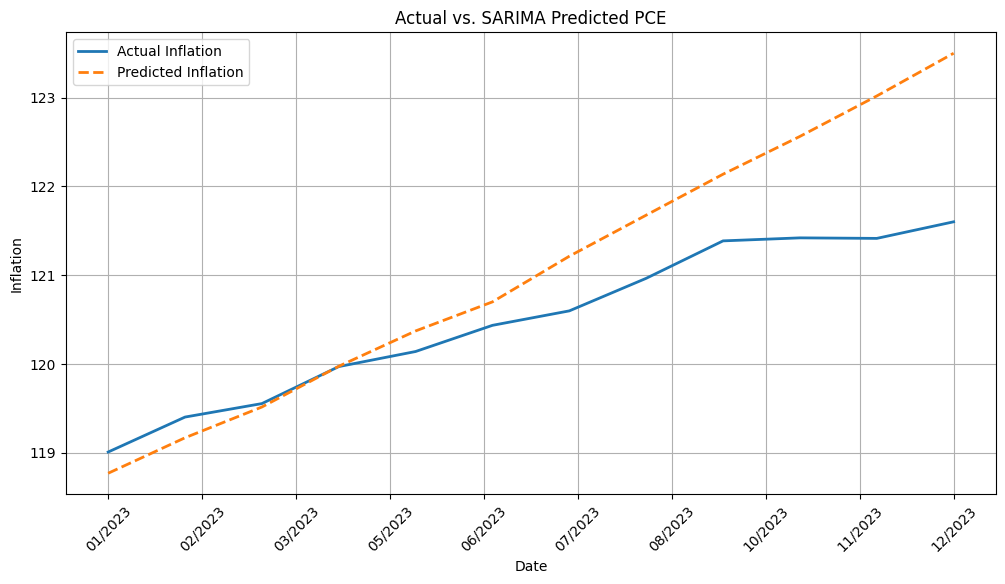

In [7]:
#change seasonal to True and m=12 for SARIMA
sarima_model= pm.auto_arima(y_train,start_p=1, start_q=1,seasonal=True,m=12, stepwise=True)
preds=np.array(sarima_model.predict(y_valid.shape[0]))
Y= np.array(y_valid.iloc[:])
print(f'RMSE: {root_mean_squared_error(Y,preds)}')
display_results(Y, preds, list(y_valid.index), 'SARIMA', print_dates=10)
plt.show()

In [8]:
sarima_full_train= pm.auto_arima(y_train_full,start_p=1, start_q=1,m=12,seasonal=True, stepwise=True)
with open(f'SARIMA{START_YEAR}{DATA_INFO}.pkl','wb') as f:
    pickle.dump(sarima_full_train,f)

## SARIMAX

In [ ]:
#change seasonal to True and m=12 for SARIMA
sarimax_model= pm.auto_arima(y=y_train,X=X_train,start_p=1, start_q=1,m=12,seasonal=True, stepwise=True)
preds=np.array(sarimax_model.predict(y_valid.shape[0],X_valid))
Y= np.array(y_valid)

print(f'RMSE: {root_mean_squared_error(Y,preds)}')
display_results(Y, preds, list(y_valid.index), 'SARIMAX', print_dates=10)
plt.show()

As shown ARIMAX and SARIMAX are sensitive to large numbers of exogenous variables, therefore some method is required to rank the best features:
mutual_info_regression
cross correlation
Variance Inflation Factor (VIF) (Remove variables with VIF > 5–10 to avoid unstable coefficient estimates)

## Feature Selection:
ARIMAX and SARIMAX are sensitive to the amount of feratures used and should

In [9]:
def remove_noncaused(df:pd.DataFrame, targetCol:str):

    '''
    This function removes features which are not granger caused.

    Parameters:
    -----------
    df: panda dataframe with all exogenous variables and target.

    targetCol: name of target variable in df.

    Returns:
    --------
    Returns a datframe with all features being granger caused.
    '''

    df_selected= df.copy()
    
    dropCols=[]
    # Loop over columns:
    for col in df_selected.columns.drop(targetCol):

        stationary= make_stationary(df_selected,col,targetCol)# makes stime series stationary

        #remove columns which do not achieve stationarity
        if stationary is np.nan:
            dropCols.append(col)
            
        # Removes columnns which do not granger cause (sanity check)
        elif not granger_causes(df_selected,col,targetCol):
            dropCols.append(col)
    
    return df_selected.drop(dropCols, axis=1)

def ARIMAX_grid_search(X_train, X_valid, y_train, y_valid, top_n=20, seasonal=False, verbose=False):
    '''
    Performs a grid search on the optimal number of exogenous variables to use.

    Parameters:
    -----------
    ranked_df: pandas dataframe where the columns are ordered in descending order of predictive power (ccf in this case).

    targetCol: name of target column in ranked_df.

    valid: the validation size (defaults to 10% of training data).

    top_n: gridsearch up top_n exogenous variables in total.

    Returns:
    --------
    Tuple, where the 1st element is the optimal RMSE value,
    the 2nd element is the best number of features to use. 
    '''


    # Values used to find the optimal solution
    best_score=999
    best_n=-1

    # loop over possible n's:
    for i in range(1,top_n+1):
        if verbose: print(f'Training with {i} exogenous variables...')
        #train model:
        if seasonal:
            m=12
        else:
            m=1
        arimax_model= pm.auto_arima(y=y_train,X=X_train.iloc[:,:i],start_p=1, start_q=1,m=m,seasonal=seasonal, stepwise=True)

        #Infer on the validation data:
        preds=np.array(arimax_model.predict(y_valid.shape[0],X_valid.iloc[:,:i]))
        
        # Calculate RMSE score
        Y= np.array(y_valid)
        score=root_mean_squared_error(Y,preds)

        # Update if a new minimum is found:
        if score < best_score:
            if verbose: print(f'\tNew best score:\n\t\tnum features: {i}\n\t\tScore: {score:.6f} found.')
            best_score=score
            best_n=i


    print(f"Best score: {best_score}")
    print(f"Best number of features: {best_n}")

    return best_score, best_n

## Find optimal number of exogenous variables:

In [10]:
# Remove non-granger-caused features, then find their ranking order by cross-correlation
caused_df = remove_noncaused(trainDf,'fred_PCEPI')
ranked_columns=np.delete(rank_features_ccf(caused_df,'fred_PCEPI'),[4])

In [11]:
# Reorder DataFrame of caused features according to rankings
# Removed target from caused_df to ensure has the same columns as provided for ordering, then add target back in at front
train_ranked_exog = trainDf[ranked_columns]
train_target= trainDf['fred_PCEPI']

X_train, X_valid, y_train, y_valid=train_test_split(train_ranked_exog, train_target,shuffle=False, test_size=VALID_SIZE)


## Find optimal number of features for ARIMAX:

In [12]:
best_score_arimax,best_n_arimax=ARIMAX_grid_search(X_train, X_valid, y_train, y_valid, top_n=20, seasonal= False, verbose=True)

print(f"Best score: {best_score_arimax}")
print(f"Best n: {best_n_arimax}")

Training with 1 exogenous variables...
	New best score:
		num features: 1
		Score: 0.999099 found.
Training with 2 exogenous variables...
Training with 3 exogenous variables...
Training with 4 exogenous variables...
Training with 5 exogenous variables...
Training with 6 exogenous variables...
	New best score:
		num features: 6
		Score: 0.606331 found.
Training with 7 exogenous variables...
Training with 8 exogenous variables...
	New best score:
		num features: 8
		Score: 0.603094 found.
Training with 9 exogenous variables...
Training with 10 exogenous variables...
Training with 11 exogenous variables...
Training with 12 exogenous variables...
Training with 13 exogenous variables...
Training with 14 exogenous variables...
Training with 15 exogenous variables...
Training with 16 exogenous variables...
Training with 17 exogenous variables...
Training with 18 exogenous variables...
Training with 19 exogenous variables...
Training with 20 exogenous variables...
Best score: 0.603094100748384

## Find optimal number of features for SARIMAX:

In [13]:
best_score_sarimax,best_n_sarimax=ARIMAX_grid_search(X_train, X_valid, y_train, y_valid, top_n=20, seasonal= True, verbose=True)

print(f"Best score: {best_score_sarimax}")
print(f"Best n: {best_n_sarimax}")

Training with 1 exogenous variables...
	New best score:
		num features: 1
		Score: 0.999099 found.
Training with 2 exogenous variables...
	New best score:
		num features: 2
		Score: 0.871265 found.
Training with 3 exogenous variables...
Training with 4 exogenous variables...
Training with 5 exogenous variables...
Training with 6 exogenous variables...
	New best score:
		num features: 6
		Score: 0.635274 found.
Training with 7 exogenous variables...
Training with 8 exogenous variables...
Training with 9 exogenous variables...
Training with 10 exogenous variables...
Training with 11 exogenous variables...
Training with 12 exogenous variables...
Training with 13 exogenous variables...
Training with 14 exogenous variables...
	New best score:
		num features: 14
		Score: 0.563997 found.
Training with 15 exogenous variables...
Training with 16 exogenous variables...
	New best score:
		num features: 16
		Score: 0.468048 found.
Training with 17 exogenous variables...
Training with 18 exogenous 

# Train final models:

trains the model using the optimal parameters and saves the model to a pickle file

# ARIMAX:

In [14]:
arimax_model_optimal_full= pm.auto_arima(y=train_target,X=train_ranked_exog.iloc[:,:best_n_arimax],start_p=1, start_q=1,m=1,seasonal=False, stepwise=True)
with open(f'ARIMAX{START_YEAR}{DATA_INFO}.pkl','wb') as f:
    pickle.dump(arimax_model_optimal_full,f)

## SARIMAX:

In [15]:
Sarimax_model_optimal_full= pm.auto_arima(y=train_target,X=train_ranked_exog.iloc[:,:best_n_sarimax],start_p=1, start_q=1,m=12,seasonal=True, stepwise=True)
with open(f'SARIMAX{START_YEAR}{DATA_INFO}.pkl','wb') as f:
    pickle.dump(Sarimax_model_optimal_full,f)

# Evaluation:

In [16]:
X_test_ranked= X_test[ranked_columns]

## ARIMA:

2025-03-30 21:10:47,511 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-30 21:10:47,513 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-30 21:10:47,515 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-30 21:10:47,517 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


RMSE: 0.2782222315502656


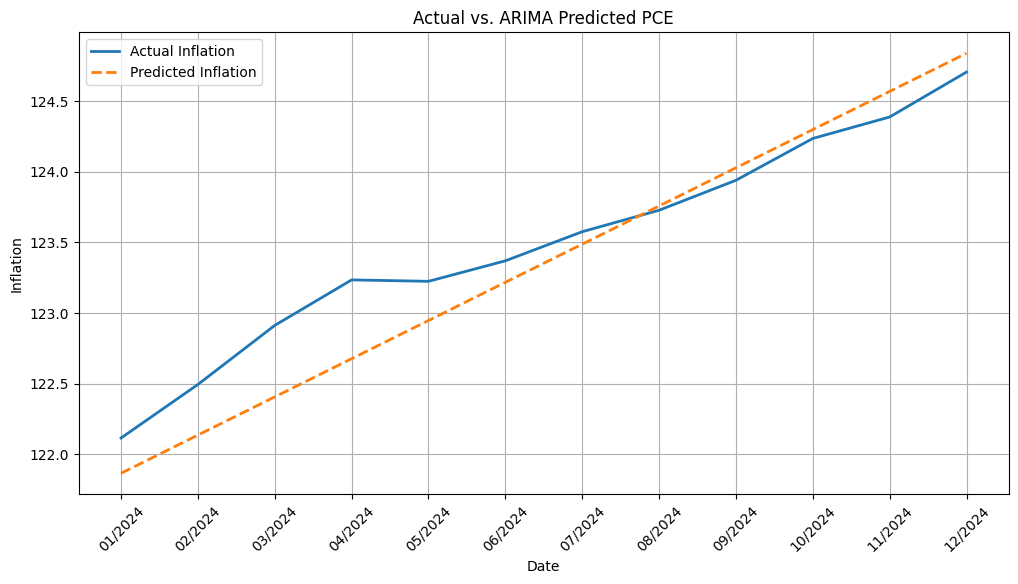

In [17]:
with open(f'ARIMA{START_YEAR}{DATA_INFO}.pkl','rb') as f:
    loaded_model=pickle.load(f)

    preds=np.array(loaded_model.predict(y_test.shape[0]))
    Y= np.array(y_test)

    print(f'RMSE: {root_mean_squared_error(Y,preds)}')
    display_results(Y, preds, list(y_test.index), 'ARIMA', print_dates=12)
    plt.show()
    np.save(f'../../Predictions/ARIMA{START_YEAR}{DATA_INFO}.npy',preds)

## SARIMA:

2025-03-30 21:10:47,969 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-30 21:10:47,971 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-30 21:10:47,973 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-30 21:10:47,975 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


RMSE: 0.33694029060942726


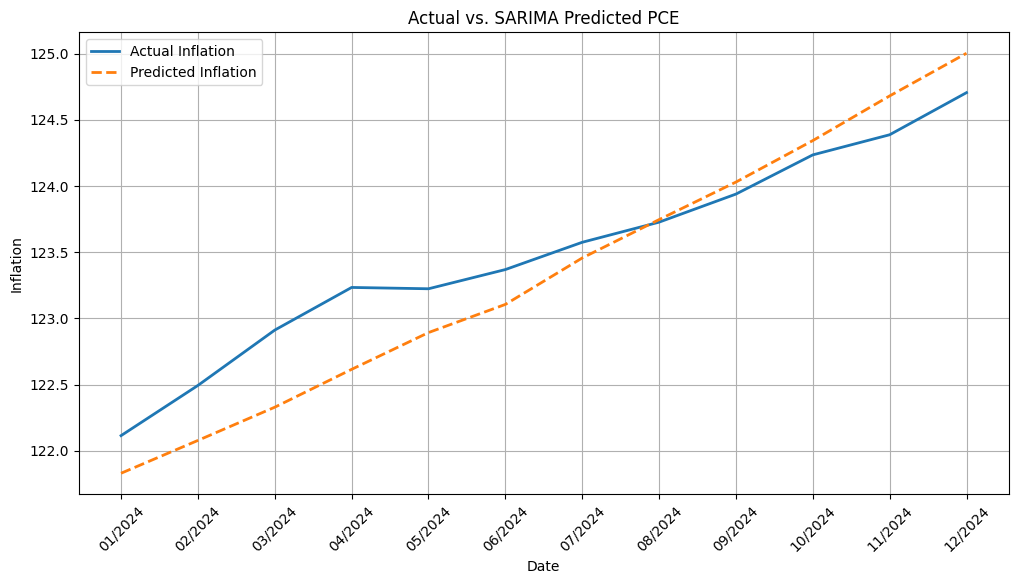

In [18]:
with open(f'SARIMA{START_YEAR}{DATA_INFO}.pkl','rb') as f:
    loaded_model=pickle.load(f)

    preds=np.array(loaded_model.predict(y_test.shape[0]))
    Y= np.array(y_test)

    print(f'RMSE: {root_mean_squared_error(Y,preds)}')
    display_results(Y, preds, list(y_test.index), 'SARIMA', print_dates=12)
    plt.show()
    np.save(f'../../Predictions/SARIMA{START_YEAR}{DATA_INFO}.npy',preds)

## ARIMAX:

2025-03-30 21:10:48,273 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-30 21:10:48,274 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-30 21:10:48,276 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-30 21:10:48,279 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


RMSE: 1.757557579445527


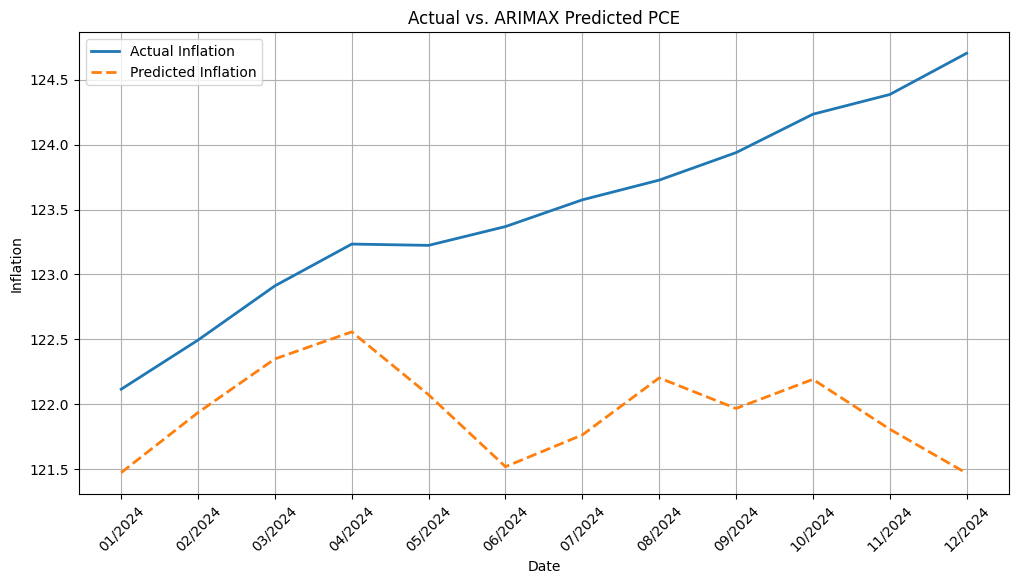

In [19]:
with open(f'ARIMAX{START_YEAR}{DATA_INFO}.pkl','rb') as f:
    loaded_model=pickle.load(f)

    preds=np.array(loaded_model.predict(y_test.shape[0],X_test_ranked.iloc[:,:best_n_arimax]))
    Y= np.array(y_test)

    print(f'RMSE: {root_mean_squared_error(Y,preds)}')
    display_results(Y, preds, list(y_test.index), 'ARIMAX', print_dates=12)
    plt.show()
    np.save(f'../../Predictions/ARIMAX{START_YEAR}{DATA_INFO}.npy',preds)

## SARIMAX:

2025-03-30 21:10:48,673 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-30 21:10:48,675 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-30 21:10:48,677 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-30 21:10:48,680 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


RMSE: 2.9240814972565747


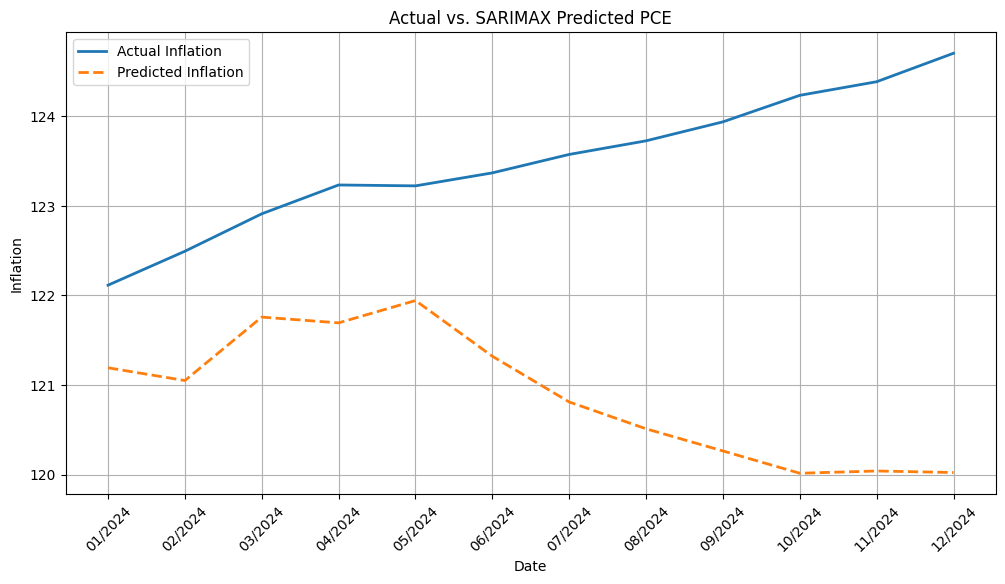

In [20]:
with open(f'SARIMAX{START_YEAR}{DATA_INFO}.pkl','rb') as f:
    loaded_model=pickle.load(f)

    preds=np.array(loaded_model.predict(y_test.shape[0],X_test_ranked.iloc[:,:best_n_sarimax]))
    Y= np.array(y_test)

    print(f'RMSE: {root_mean_squared_error(Y,preds)}')
    display_results(Y, preds, list(y_test.index), 'SARIMAX', print_dates=12)
    plt.show()
    np.save(f'../../Predictions/SARIMAX{START_YEAR}{DATA_INFO}.npy',preds)